<a href="https://colab.research.google.com/github/enakai00/colab_GenAI_lecture/blob/main/08_Conditional_VAE_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, random
os.environ['PYTHONHASHSEED'] = str(20230629)
random.seed(20240329)

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers, models

from tensorflow.keras.datasets import fashion_mnist

np.random.seed(20230629)
tf.random.set_seed(20230629)

In [2]:
(train_images, train_labels), _ = fashion_mnist.load_data()
train_images = np.pad(train_images, ((0, 0), (2, 2), (2, 2)), constant_values=0)
train_images = train_images.reshape((len(train_images), 32*32)).astype('float32') / 255
train_labels = tf.keras.utils.to_categorical(train_labels, 10)

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
encoder = models.load_model('/content/gdrive/My Drive/conditional_VAE_encoder.hd5')
encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 32, 32, 1)         0         
                                                                 
 conv_filter1 (Conv2D)       (None, 16, 16, 32)        320       
                                                                 
 conv_filter2 (Conv2D)       (None, 8, 8, 64)          18496     
                                                                 
 conv_filter3 (Conv2D)       (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 mean_and_log_var (Dense)    (None, 4)                 8196      
                                                                 
Total params: 100,868
Trainable params: 100,868
Non-trai

In [7]:
decoder = models.load_model('/content/gdrive/My Drive/conditional_VAE_decoder.hd5')
decoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 expand (Dense)              (None, 2048)              26624     
                                                                 
 reshape2 (Reshape)          (None, 4, 4, 128)         0         
                                                                 
 conv_transpose1 (Conv2DTran  (None, 8, 8, 64)         73792     
 spose)                                                          
                                                                 
 conv_transpose2 (Conv2DTran  (None, 16, 16, 32)       18464     
 spose)                                                          
                                                                 
 conv_transpose3 (Conv2DTran  (None, 32, 32, 1)        289       
 spose)                                                          
                                                      

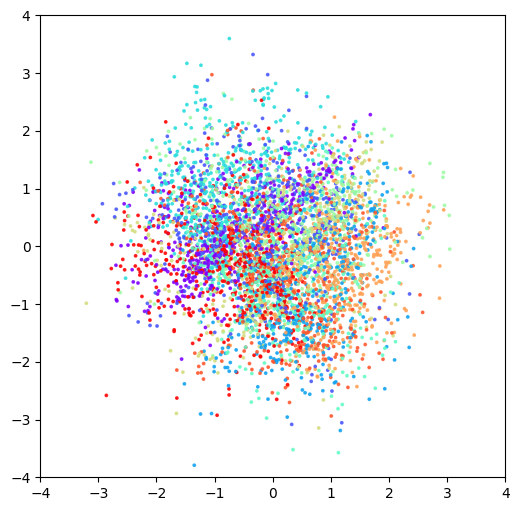

In [9]:
embeddings = encoder.predict(train_images[:5000], verbose=0)
example_labels = np.argmax(train_labels[:5000], axis=1)

fig = plt.figure(figsize=(6, 6))
subplot = fig.add_subplot(1, 1, 1)
subplot.set_xlim((-4, 4))
subplot.set_ylim((-4, 4))
_ = subplot.scatter(embeddings[:, 0], embeddings[:, 1],
                    cmap='rainbow', c=example_labels, alpha=0.8, s=3)

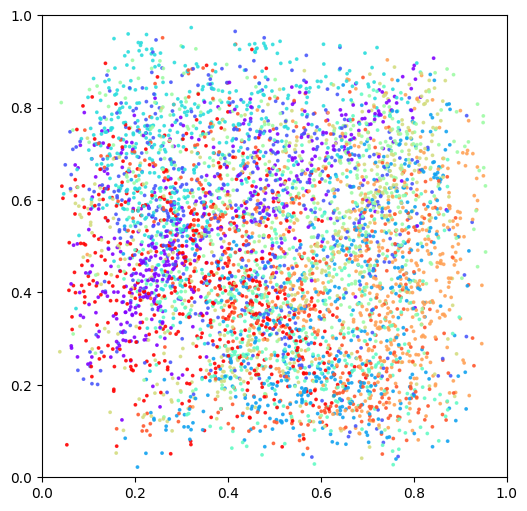

In [10]:
sigmoid = lambda x: 1/(1 + np.exp(-x))
logit = lambda x: np.log(x)-np.log(1-x)

fig = plt.figure(figsize=(6, 6))
subplot = fig.add_subplot(1, 1, 1)
subplot.set_xlim((0, 1))
subplot.set_ylim((0, 1))
_ = subplot.scatter(sigmoid(embeddings[:, 0]), sigmoid(embeddings[:, 1]),
                    cmap='rainbow', c=example_labels, alpha=0.8, s=3)

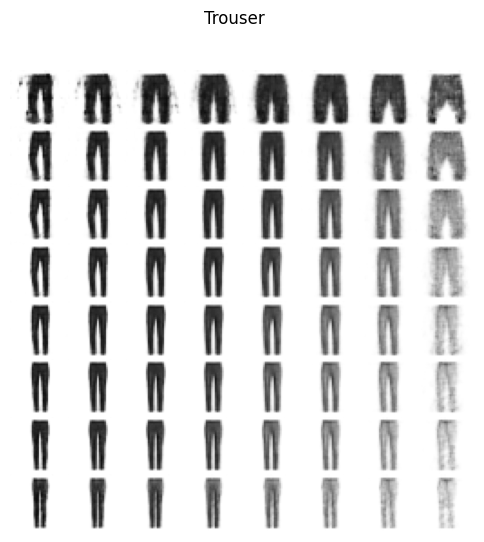

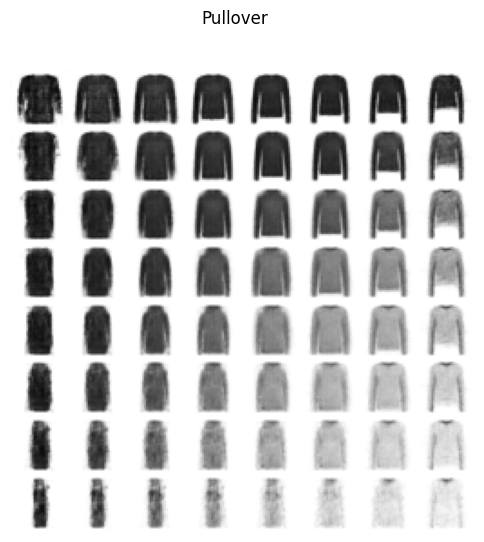

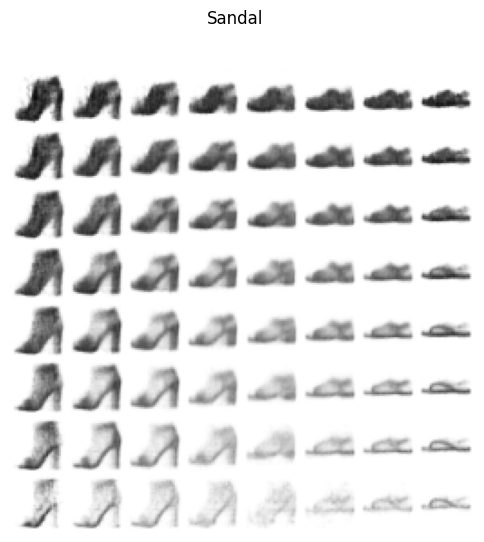

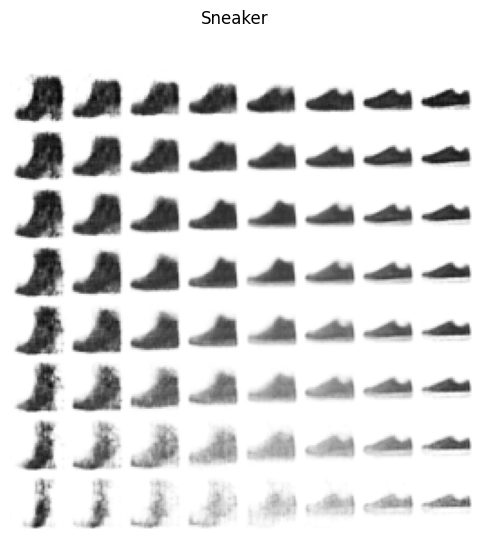

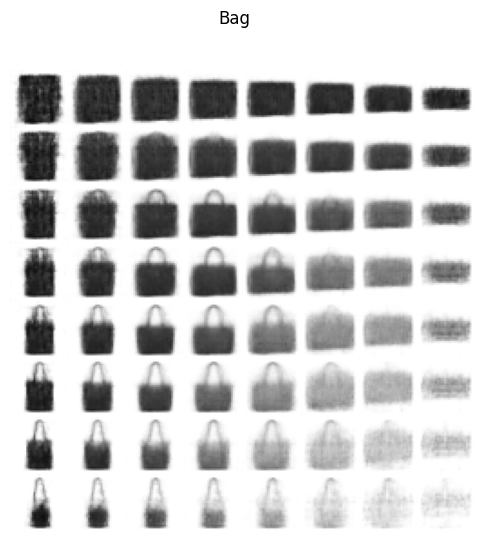

In [11]:
import copy
from matplotlib import colormaps

labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
          'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

for i in [1, 2, 5, 7, 8]:
    fig = plt.figure(figsize=(6, 6))
    x = np.linspace(0.1, 0.9, 8)
    y = np.linspace(0.1, 0.9, 8)
    xv, yv = np.meshgrid(x, y)
    xv = xv.flatten()
    yv = yv.flatten()
    label = [0] * 10
    label[i] = 1
    grid = np.array(list(zip(logit(xv), logit(yv))))
    grid = np.hstack([grid, np.tile(label, len(grid)).reshape(len(grid), 10)])
    reconstructions = decoder.predict(grid, verbose=0)
    fig.subplots_adjust(hspace=0, wspace=0)
    fig.suptitle(labels[i])
    for i in range(8*8):
        subplot = fig.add_subplot(8, 8, i + 1)
        subplot.axis('off')
        subplot.imshow(reconstructions[i].reshape((32, 32)),
                       vmin=0, vmax=1, cmap=plt.cm.gray_r)